# Overview

With increasing research in Deep Learning, Computer Vision, and Natural Language Processing, we have seen new advancements in these fields, image captioning being one of them. This notebook is attempt to apply image captioning with Visual Attention, as described in “Show, Attend and Tell: Neural Image Caption Generation with Visual Attention” and how I used the model architecture described in their paper to generate findings of Chest X Rays.

Link to the paper: https://arxiv.org/abs/1502.03044

# Model Architecture

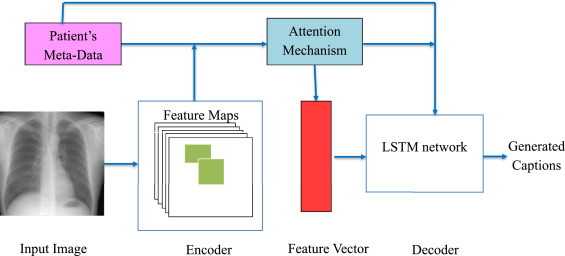

# About Dataset

The datasets used for this project are the National Institute of Health Chest X-Ray Dataset to train the CNN feature extractor model (CheXNet) and the Chest X-rays (Indiana University) dataset to train the model with the captions.

#### Highlights of this notebook:
1. Image Feature Extraction, using CheXNet.
2. Text Pre-Processing and Cleaning.
3. Building Caption Generation Model Architecture. 
4. Model Evaluation.

This Notebook is running using Accelerator of type GPU T4 x2.

## <font size=4 color='blue'>If you find this notebook useful, leave an upvote, that motivates me to write more such notebooks.</font>

## 1. Loading Libraries and Dataset. 

In [ ]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np
from numpy import array
import pandas as pd
import cv2
from glob import glob
import PIL
import time
from tqdm import tqdm
import os

In [ ]:
image_path = "/kaggle/input/chest-xrays-indiana-university/images/images_normalized/"
images = glob(image_path + "*.png")
len(images)

In [ ]:
for i in range(5):
    plt.figure()
    image = cv2.imread(images[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)

## 2. Creating Image, Caption Dictionary.

In [ ]:
import re
# Read in the projections data
projections = pd.read_csv('/kaggle/input/chest-xrays-indiana-university/indiana_projections.csv')

# Read in the reports data
reports = pd.read_csv('/kaggle/input/chest-xrays-indiana-university/indiana_reports.csv')

# Define the path to the images folder
images_folder = '/kaggle/input/chest-xrays-indiana-university/images/images_normalized'

# Merge the projections and reports data on the UID column
reports = pd.merge(projections, reports, on='uid')

# Create a dictionary of image filenames and their corresponding captions
data = {}
for i in range(len(reports)):
    filename = reports.loc[i, 'filename']
    caption = reports.loc[i, 'impression']
    if filename not in data:
        data[filename] = []
    if isinstance(caption, str) and re.match(r'^\d+\.', caption):
        data[filename].append(caption.split('. ')[1])
    else:
        if data[filename]:
            data[filename][-1] += " " + caption
        else:
            data[filename].append(caption)

## 3. Captions Pre-Processing.

In [ ]:
def cleanse_data(data):
    dict_2 = dict()
    for key, value in data.items():
        for i in range(len(value)):
            lines = ""
            line1 = value[i]
            if isinstance(line1, str):
                for j in line1.split():
                    if len(j) < 2:
                        continue
                    j = j.lower()
                    lines += j + " "
                if key not in dict_2:
                    dict_2[key] = list()
                dict_2[key].append(lines)
    return dict_2

data2 = cleanse_data(data)
print(len(data2))

In [ ]:
# convert the following into a vocabulary of words and calculate the total words

def vocabulary(data2):
    all_desc = set()
    for key in data2.keys():
        [all_desc.update(d.split()) for d in data2[key]]
    return all_desc

# summarize vocabulary
vocabulary_data = vocabulary(data2)
print(len(vocabulary_data))

In [ ]:
def save_dict(data2, filename):
    lines = list()
    for key, value in data2.items():
        for desc in value:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

save_dict(data2, 'captions1.txt')

## 4. Images Feature Exraction.

In [ ]:
#images = '/kaggle/input/chest-xrays-indiana-university/images/images_normalized/'
#img = glob(images + '*.png')
#print(len(img))

#def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    #img = keras.preprocessing.image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    #x = keras.preprocessing.image.img_to_array(img)
    # Add one more dimension
    #x = np.expand_dims(x, axis=0)
    # pre-process the images using preprocess_input() from inception module
    #x = tf.keras.applications.xception.preprocess_input(x)
    #return x

In [ ]:
#from keras.applications.xception import Xception
#from keras.models import Model

# Load the Xception model
#input1 = Xception(weights='imagenet')

# Create a new model, by removing the last layer (output layer) from the Xception model
#model = Model(input1.input, input1.layers[-2].output)

#model.summary()

In [ ]:
# Function to encode a given image into a vector of size (2048, )
#def encode(image):
    #image = preprocess(image) # preprocess the image
    #fea_vec = model.predict(image) # Get the encoding vector for the image
    #fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    #return fea_vec
    
#encoding = {}

#for i in tqdm(img):
    #encoding[i[len(images):]] = encode(i)
    
#import pickle

# Save the features in the images1 pickle file
#with open("images1.pkl", "wb") as encoded_pickle:
    #pickle.dump(encoding, encoded_pickle)

In [ ]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, GlobalAveragePooling2D
from keras.layers import Flatten, Concatenate, Dropout, BatchNormalization
from keras.regularizers import l2
from keras import backend as K
from keras.applications.densenet import DenseNet121
from keras.applications.densenet import preprocess_input
import numpy as np
import pickle
import os
from tqdm import tqdm
from tensorflow.keras.utils import load_img, img_to_array

def chexnet(input_shape=(224,224,3), weights_path=None):
    input_layer = Input(shape=input_shape, name='input_1')
    densenet = DenseNet121(weights=None, include_top=False, input_tensor=input_layer)

    if weights_path is not None:
        densenet.load_weights(weights_path, by_name=True)

    x = densenet.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(14, activation='sigmoid', kernel_regularizer=l2(0.0001))(x)
    model = Model(inputs=densenet.input, outputs=predictions)

    return model

# Define the input shape of the model
input_shape = (224, 224, 3)

# Load the pre-trained CheXNet model
base_model = chexnet(input_shape=input_shape, weights_path='/kaggle/input/chexnet-weights/brucechou1983_CheXNet_Keras_0.3.0_weights.h5')

# Function to encode a given image into a vector
def encode(image):
    image = preprocess_input(image) # preprocess the image
    fea_vec = base_model.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape
    return fea_vec

# Define the directory containing the chest X-ray images
img_dir = '/kaggle/input/chest-xrays-indiana-university/images/images_normalized'

# Get a list of all the image filenames in the directory
img_list = os.listdir(img_dir)

encoding = {}

for img_filename in tqdm(img_list):
    # Load the image from the file
    img_path = os.path.join(img_dir, img_filename)
    img = load_img(img_path, target_size=input_shape[:2])
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)

    # Encode the image and store the encoding vector
    encoding[img_filename] = encode(x)

# Save the encoding vectors as a pickle file
with open("encodings.pkl", "wb") as f:
    pickle.dump(encoding, f)

## 5. Creating Training Captions. 

In [ ]:
# Create a list of all the training captions

all_train_captions = []

for key, val in data2.items():
    for cap in val:
        all_train_captions.append(cap)
        
len(all_train_captions)

# Consider only words which occur at least 10 times in the corpus

word_count_threshold = 10
word_counts = {}
nsents = 0

for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

# Converting the words to indices and vice versa.

ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1
    
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

# Save the words to index and index to word as pickle files

with open("words.pkl", "wb") as encoded_pickle:
    pickle.dump(wordtoix, encoded_pickle)
    
with open("words1.pkl", "wb") as encoded_pickle:
    pickle.dump(ixtoword, encoded_pickle)
    
# convert a dictionary of clean descriptions to a list of descriptions

def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(data2)
print('Description Length: %d' % max_length)

In [ ]:
# data generator, intended to be used in a call to model.fit_generator()

def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key]
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield ([array(X1), array(X2)], array(y))
                X1, X2, y = list(), list(), list()
                n=0

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

!unzip glove.6B.zip

## 6. Creating Embedding Matrix.

In [ ]:
# Download, install, and then Load the Glove vectors
# https://github.com/stanfordnlp/GloVe

embeddings_index = {} # empty dictionary
f = open('glove.6B.200d.txt', encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros,
        embedding_matrix[i] = embedding_vector
        
embedding_matrix.shape

## 7. Caption Generation Model Architecture.

In [ ]:
from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPool2D, LSTM, add
from tensorflow.keras.layers import Activation, Dropout, Flatten, Embedding
from tensorflow.keras.models import Model

inputs1 = Input(shape=(None, 10, 14))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()


## 8. Model Training.

In [ ]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

model.compile(loss='categorical_crossentropy', optimizer='adam')

epochs = 4
number_pics_per_bath = 3
steps = len(data2)//number_pics_per_bath

features = pickle.load(open("encodings.pkl", "rb"))

# https://stackoverflow.com/questions/58352326/running-the-tensorflow-2-0-code-gives-valueerror-tf-function-decorated-functio

tf.config.run_functions_eagerly(True)

for i in range(epochs):
    generator = data_generator(data2, features, wordtoix, max_length, number_pics_per_bath)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('model_' + str(i) + '.h5')

## 9. Model Evaluation

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [ ]:
features = pickle.load(open("encodings.pkl", "rb"))
model = load_model('model_3.h5')
images = "/kaggle/input/chest-xrays-indiana-university/images/images_normalized/"
max_length = 124
words_to_index = pickle.load(open("words.pkl", "rb"))
index_to_words = pickle.load(open("words1.pkl", "rb"))

In [ ]:
def Image_Caption(picture):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [words_to_index[w] for w in in_text.split() if w in words_to_index]
        sequence = pad_sequences([sequence], maxlen=max_length)
        # Modify the following line to ensure that both arrays have the same number of samples
        yhat = model.predict([np.repeat(picture, len(sequence), axis=0), sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = index_to_words[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    #final = in_text.split()
    #final = final[1:-1]
    #final = ' '.join(final)
    return in_text

In [ ]:
z = 2000
pic = list(features.keys())[z]
#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = features[pic].reshape((1,14))
x = plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Caption:", Image_Caption(image))

## Thanks a lot for reading all the way

# <font size=4 color='blue'>If you find this notebook useful, leave an upvote, that motivates me to write more such notebooks.</font>